# AP(P)3RO PROJECT #

### Projet de deneigement intelligent de Montréal, Canada ###

#### M. Le Gras, A. Naullet, A. Calixte, P. Beaunieux ####

In [4]:
import multiprocessing as mp

import numpy as np
import osmnx as ox

## Partie 1: Cartographie de la ville par le drone ##

In [ ]:
place = "Montreal, Canada" # /!\ Replace with Montreal
G = ox.graph_from_place(place, network_type="walk")
#Gp = ox.project_graph(G)

### 1.1: Importation des plans de la ville ###

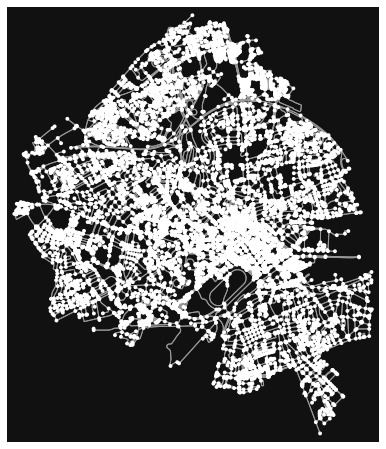

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ox.plot_graph(G)

In [7]:
#node1 =list(G.nodes(data=True))[2][0]
#node2 =list(G.nodes(data=True))[42][0]
#print(list(G.nodes(data=True))[2:4])
#print(node1, node2)
node_list = list(G.edges(data=True))
print(len(node_list))

28658


In [19]:
### Construction d'une liste de noeud qui a notre format
graph_city = []
for node in node_list:
    n1 = node[0]
    n2 = node[1]
    dist = node[2]["length"]
    graph_city.append((n1,n2,dist))
### On ne peut pas utiliser l'id des noeuds pour utiliser nos algos.
### On doit construire une table de correspondance entre l'id des noeuds et des numéros croissants de noeuds

CORRESPONDENCE_TABLE = {}
CORRESPONDENCE_TABLE_PRIME = {}

def get_true_node(soft_id):
    if soft_id in CORRESPONDENCE_TABLE_PRIME:
        return CORRESPONDENCE_TABLE_PRIME[soft_id]
    return -1

def to_soft_id_graph(graph_city):
    graph_city_soft_id = []
    soft_id = 1
    
    len_g = len(graph_city)
    index = 1
    
    old_percentage = -1
    for (node1,node2,dist) in graph_city:
        #percentage = (index*100)//len_g
        #print("to soft_id: ",percentage, "%")
        #old_percentage = percentage
        if node1 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node1] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node1
            soft_id += 1
            
        if node2 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node2] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node2
            
            soft_id += 1
        s_id1 = CORRESPONDENCE_TABLE[node1]
        s_id2 = CORRESPONDENCE_TABLE[node2]
        graph_city_soft_id.append((s_id1,s_id2, dist))
    return graph_city_soft_id

def to_real_id_graph(graph_city_soft_id):
    graph_city = []
    soft_id = 1
    for (node1,node2,dist) in graph_city_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        graph_city.append((n_id1,n_id2, dist))
    return graph_city

def to_real_id_path(path_soft_id):
    path = []
    soft_id = 1
    for (node1,node2) in path_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        path.append(n_id1)
    return path

graph_city_soft_id = to_soft_id_graph(graph_city)
graph_city2 = to_real_id_graph(graph_city_soft_id)
print("DONE")
### On verifie que la conversion des graphes est OK
print("Conversion, re-conversion des graphs: ", ("Erreur","OK")[graph_city == graph_city2])

DONE
Conversion, re-conversion des graphs:  OK


In [48]:
#from caen_path import *
from scripts.eulerian_transform import *

path = transform_and_find_eulerian_path(graph_city_soft_id)

fixing the Graph
Graph fixed
Graph to dict
Starting Fleury
Calcul du chemin Eulerien: 0.0
Calcul du chemin Eulerien: 0.003488331531028709
Calcul du chemin Eulerien: 0.006976663062057418
Calcul du chemin Eulerien: 0.010464994593086127
Calcul du chemin Eulerien: 0.013953326124114837
Calcul du chemin Eulerien: 0.017441657655143546
Calcul du chemin Eulerien: 0.020929989186172254
Calcul du chemin Eulerien: 0.024418320717200962
Calcul du chemin Eulerien: 0.027906652248229673
Calcul du chemin Eulerien: 0.03139498377925838
Calcul du chemin Eulerien: 0.03488331531028709
Calcul du chemin Eulerien: 0.0383716468413158
Calcul du chemin Eulerien: 0.04185997837234451
Calcul du chemin Eulerien: 0.04534830990337322
Calcul du chemin Eulerien: 0.048836641434401924
Calcul du chemin Eulerien: 0.052324972965430636
Calcul du chemin Eulerien: 0.05581330449645935
Calcul du chemin Eulerien: 0.05930163602748805
Calcul du chemin Eulerien: 0.06278996755851676
Calcul du chemin Eulerien: 0.06627829908954547
Calcul d

Calcul du chemin Eulerien: 0.6139463494610528
Calcul du chemin Eulerien: 0.6174346809920815
Calcul du chemin Eulerien: 0.6209230125231102
Calcul du chemin Eulerien: 0.6244113440541389
Calcul du chemin Eulerien: 0.6278996755851676
Calcul du chemin Eulerien: 0.6313880071161964
Calcul du chemin Eulerien: 0.634876338647225
Calcul du chemin Eulerien: 0.6383646701782537
Calcul du chemin Eulerien: 0.6418530017092825
Calcul du chemin Eulerien: 0.6453413332403112
Calcul du chemin Eulerien: 0.6488296647713399
Calcul du chemin Eulerien: 0.6523179963023685
Calcul du chemin Eulerien: 0.6558063278333973
Calcul du chemin Eulerien: 0.659294659364426
Calcul du chemin Eulerien: 0.6627829908954547
Calcul du chemin Eulerien: 0.6662713224264835
Calcul du chemin Eulerien: 0.6697596539575121
Calcul du chemin Eulerien: 0.6732479854885408
Calcul du chemin Eulerien: 0.6767363170195695
Calcul du chemin Eulerien: 0.6802246485505983
Calcul du chemin Eulerien: 0.683712980081627
Calcul du chemin Eulerien: 0.68720131

Calcul du chemin Eulerien: 1.2383576935151916
Calcul du chemin Eulerien: 1.2418460250462204
Calcul du chemin Eulerien: 1.245334356577249
Calcul du chemin Eulerien: 1.2488226881082778
Calcul du chemin Eulerien: 1.2523110196393066
Calcul du chemin Eulerien: 1.2557993511703351
Calcul du chemin Eulerien: 1.259287682701364
Calcul du chemin Eulerien: 1.2627760142323927
Calcul du chemin Eulerien: 1.2662643457634213
Calcul du chemin Eulerien: 1.26975267729445
Calcul du chemin Eulerien: 1.2732410088254789
Calcul du chemin Eulerien: 1.2767293403565074
Calcul du chemin Eulerien: 1.2802176718875362
Calcul du chemin Eulerien: 1.283706003418565
Calcul du chemin Eulerien: 1.2871943349495936
Calcul du chemin Eulerien: 1.2906826664806224
Calcul du chemin Eulerien: 1.294170998011651
Calcul du chemin Eulerien: 1.2976593295426797
Calcul du chemin Eulerien: 1.3011476610737085
Calcul du chemin Eulerien: 1.304635992604737
Calcul du chemin Eulerien: 1.3081243241357658
Calcul du chemin Eulerien: 1.311612655666

Calcul du chemin Eulerien: 1.8767223636934454
Calcul du chemin Eulerien: 1.8802106952244741
Calcul du chemin Eulerien: 1.883699026755503
Calcul du chemin Eulerien: 1.8871873582865315
Calcul du chemin Eulerien: 1.8906756898175603
Calcul du chemin Eulerien: 1.894164021348589
Calcul du chemin Eulerien: 1.8976523528796176
Calcul du chemin Eulerien: 1.9011406844106464
Calcul du chemin Eulerien: 1.904629015941675
Calcul du chemin Eulerien: 1.9081173474727038
Calcul du chemin Eulerien: 1.9116056790037326
Calcul du chemin Eulerien: 1.9150940105347611
Calcul du chemin Eulerien: 1.91858234206579
Calcul du chemin Eulerien: 1.9220706735968187
Calcul du chemin Eulerien: 1.9255590051278473
Calcul du chemin Eulerien: 1.929047336658876
Calcul du chemin Eulerien: 1.9325356681899049
Calcul du chemin Eulerien: 1.9360239997209334
Calcul du chemin Eulerien: 1.9395123312519622
Calcul du chemin Eulerien: 1.943000662782991
Calcul du chemin Eulerien: 1.9464889943140196
Calcul du chemin Eulerien: 1.949977325845

Calcul du chemin Eulerien: 2.508110370809642
Calcul du chemin Eulerien: 2.5115987023406703
Calcul du chemin Eulerien: 2.515087033871699
Calcul du chemin Eulerien: 2.518575365402728
Calcul du chemin Eulerien: 2.5220636969337566
Calcul du chemin Eulerien: 2.5255520284647854
Calcul du chemin Eulerien: 2.529040359995814
Calcul du chemin Eulerien: 2.5325286915268426
Calcul du chemin Eulerien: 2.5360170230578714
Calcul du chemin Eulerien: 2.5395053545889
Calcul du chemin Eulerien: 2.542993686119929
Calcul du chemin Eulerien: 2.5464820176509577
Calcul du chemin Eulerien: 2.549970349181986
Calcul du chemin Eulerien: 2.553458680713015
Calcul du chemin Eulerien: 2.5569470122440436
Calcul du chemin Eulerien: 2.5604353437750724
Calcul du chemin Eulerien: 2.563923675306101
Calcul du chemin Eulerien: 2.56741200683713
Calcul du chemin Eulerien: 2.5709003383681583
Calcul du chemin Eulerien: 2.574388669899187
Calcul du chemin Eulerien: 2.577877001430216
Calcul du chemin Eulerien: 2.5813653329612447
Cal

Calcul du chemin Eulerien: 3.139498377925838
Calcul du chemin Eulerien: 3.1429867094568666
Calcul du chemin Eulerien: 3.1464750409878954
Calcul du chemin Eulerien: 3.149963372518924
Calcul du chemin Eulerien: 3.153451704049953
Calcul du chemin Eulerien: 3.156940035580982
Calcul du chemin Eulerien: 3.16042836711201
Calcul du chemin Eulerien: 3.163916698643039
Calcul du chemin Eulerien: 3.1674050301740677
Calcul du chemin Eulerien: 3.1708933617050965
Calcul du chemin Eulerien: 3.1743816932361253
Calcul du chemin Eulerien: 3.177870024767154
Calcul du chemin Eulerien: 3.1813583562981824
Calcul du chemin Eulerien: 3.184846687829211
Calcul du chemin Eulerien: 3.18833501936024
Calcul du chemin Eulerien: 3.191823350891269
Calcul du chemin Eulerien: 3.1953116824222976
Calcul du chemin Eulerien: 3.198800013953326
Calcul du chemin Eulerien: 3.2022883454843547
Calcul du chemin Eulerien: 3.2057766770153835
Calcul du chemin Eulerien: 3.2092650085464123
Calcul du chemin Eulerien: 3.212753340077441
Ca

Calcul du chemin Eulerien: 3.777863048104092
Calcul du chemin Eulerien: 3.7813513796351206
Calcul du chemin Eulerien: 3.7848397111661494
Calcul du chemin Eulerien: 3.788328042697178
Calcul du chemin Eulerien: 3.7918163742282065
Calcul du chemin Eulerien: 3.7953047057592353
Calcul du chemin Eulerien: 3.798793037290264
Calcul du chemin Eulerien: 3.802281368821293
Calcul du chemin Eulerien: 3.8057697003523216
Calcul du chemin Eulerien: 3.80925803188335
Calcul du chemin Eulerien: 3.812746363414379
Calcul du chemin Eulerien: 3.8162346949454076
Calcul du chemin Eulerien: 3.8197230264764364
Calcul du chemin Eulerien: 3.823211358007465
Calcul du chemin Eulerien: 3.826699689538494
Calcul du chemin Eulerien: 3.8301880210695223
Calcul du chemin Eulerien: 3.833676352600551
Calcul du chemin Eulerien: 3.83716468413158
Calcul du chemin Eulerien: 3.8406530156626086
Calcul du chemin Eulerien: 3.8441413471936374
Calcul du chemin Eulerien: 3.847629678724666
Calcul du chemin Eulerien: 3.8511180102556946
C

Calcul du chemin Eulerien: 4.4127393867513165
Calcul du chemin Eulerien: 4.416227718282346
Calcul du chemin Eulerien: 4.419716049813374
Calcul du chemin Eulerien: 4.423204381344403
Calcul du chemin Eulerien: 4.426692712875432
Calcul du chemin Eulerien: 4.43018104440646
Calcul du chemin Eulerien: 4.433669375937489
Calcul du chemin Eulerien: 4.437157707468518
Calcul du chemin Eulerien: 4.440646038999547
Calcul du chemin Eulerien: 4.444134370530575
Calcul du chemin Eulerien: 4.447622702061604
Calcul du chemin Eulerien: 4.451111033592633
Calcul du chemin Eulerien: 4.454599365123661
Calcul du chemin Eulerien: 4.45808769665469
Calcul du chemin Eulerien: 4.461576028185719
Calcul du chemin Eulerien: 4.465064359716748
Calcul du chemin Eulerien: 4.468552691247776
Calcul du chemin Eulerien: 4.4720410227788046
Calcul du chemin Eulerien: 4.475529354309834
Calcul du chemin Eulerien: 4.479017685840862
Calcul du chemin Eulerien: 4.482506017371891
Calcul du chemin Eulerien: 4.48599434890292
Calcul du c

Calcul du chemin Eulerien: 5.061569051522657
Calcul du chemin Eulerien: 5.065057383053685
Calcul du chemin Eulerien: 5.068545714584714
Calcul du chemin Eulerien: 5.072034046115743
Calcul du chemin Eulerien: 5.075522377646772
Calcul du chemin Eulerien: 5.0790107091778
Calcul du chemin Eulerien: 5.082499040708829
Calcul du chemin Eulerien: 5.085987372239858
Calcul du chemin Eulerien: 5.089475703770886
Calcul du chemin Eulerien: 5.092964035301915
Calcul du chemin Eulerien: 5.096452366832944
Calcul du chemin Eulerien: 5.099940698363972
Calcul du chemin Eulerien: 5.103429029895001
Calcul du chemin Eulerien: 5.10691736142603
Calcul du chemin Eulerien: 5.110405692957059
Calcul du chemin Eulerien: 5.113894024488087
Calcul du chemin Eulerien: 5.117382356019116
Calcul du chemin Eulerien: 5.120870687550145
Calcul du chemin Eulerien: 5.124359019081173
Calcul du chemin Eulerien: 5.127847350612202
Calcul du chemin Eulerien: 5.131335682143231
Calcul du chemin Eulerien: 5.13482401367426
Calcul du chem

Calcul du chemin Eulerien: 5.710398716293996
Calcul du chemin Eulerien: 5.713887047825025
Calcul du chemin Eulerien: 5.717375379356054
Calcul du chemin Eulerien: 5.720863710887083
Calcul du chemin Eulerien: 5.724352042418111
Calcul du chemin Eulerien: 5.72784037394914
Calcul du chemin Eulerien: 5.731328705480169
Calcul du chemin Eulerien: 5.734817037011197
Calcul du chemin Eulerien: 5.7383053685422265
Calcul du chemin Eulerien: 5.741793700073255
Calcul du chemin Eulerien: 5.745282031604284
Calcul du chemin Eulerien: 5.748770363135312
Calcul du chemin Eulerien: 5.752258694666341
Calcul du chemin Eulerien: 5.75574702619737
Calcul du chemin Eulerien: 5.759235357728398
Calcul du chemin Eulerien: 5.762723689259428
Calcul du chemin Eulerien: 5.766212020790456
Calcul du chemin Eulerien: 5.769700352321484
Calcul du chemin Eulerien: 5.7731886838525135
Calcul du chemin Eulerien: 5.776677015383542
Calcul du chemin Eulerien: 5.780165346914571
Calcul du chemin Eulerien: 5.783653678445599
Calcul du 

Calcul du chemin Eulerien: 6.352251718003279
Calcul du chemin Eulerien: 6.355740049534308
Calcul du chemin Eulerien: 6.3592283810653365
Calcul du chemin Eulerien: 6.362716712596365
Calcul du chemin Eulerien: 6.366205044127394
Calcul du chemin Eulerien: 6.369693375658422
Calcul du chemin Eulerien: 6.373181707189452
Calcul du chemin Eulerien: 6.37667003872048
Calcul du chemin Eulerien: 6.380158370251508
Calcul du chemin Eulerien: 6.383646701782538
Calcul du chemin Eulerien: 6.387135033313566
Calcul du chemin Eulerien: 6.390623364844595
Calcul du chemin Eulerien: 6.3941116963756235
Calcul du chemin Eulerien: 6.397600027906652
Calcul du chemin Eulerien: 6.401088359437681
Calcul du chemin Eulerien: 6.404576690968709
Calcul du chemin Eulerien: 6.408065022499739
Calcul du chemin Eulerien: 6.411553354030767
Calcul du chemin Eulerien: 6.415041685561796
Calcul du chemin Eulerien: 6.418530017092825
Calcul du chemin Eulerien: 6.422018348623853
Calcul du chemin Eulerien: 6.425506680154882
Calcul du

Calcul du chemin Eulerien: 6.994104719712562
Calcul du chemin Eulerien: 6.99759305124359
Calcul du chemin Eulerien: 7.001081382774619
Calcul du chemin Eulerien: 7.004569714305648
Calcul du chemin Eulerien: 7.008058045836676
Calcul du chemin Eulerien: 7.011546377367705
Calcul du chemin Eulerien: 7.0150347088987335
Calcul du chemin Eulerien: 7.018523040429763
Calcul du chemin Eulerien: 7.022011371960791
Calcul du chemin Eulerien: 7.02549970349182
Calcul du chemin Eulerien: 7.028988035022849
Calcul du chemin Eulerien: 7.032476366553877
Calcul du chemin Eulerien: 7.035964698084906
Calcul du chemin Eulerien: 7.0394530296159346
Calcul du chemin Eulerien: 7.042941361146964
Calcul du chemin Eulerien: 7.046429692677992
Calcul du chemin Eulerien: 7.0499180242090205
Calcul du chemin Eulerien: 7.05340635574005
Calcul du chemin Eulerien: 7.056894687271078
Calcul du chemin Eulerien: 7.060383018802107
Calcul du chemin Eulerien: 7.063871350333136
Calcul du chemin Eulerien: 7.067359681864164
Calcul du 

Calcul du chemin Eulerien: 7.642934384483901
Calcul du chemin Eulerien: 7.64642271601493
Calcul du chemin Eulerien: 7.649911047545959
Calcul du chemin Eulerien: 7.653399379076988
Calcul du chemin Eulerien: 7.656887710608016
Calcul du chemin Eulerien: 7.6603760421390446
Calcul du chemin Eulerien: 7.663864373670074
Calcul du chemin Eulerien: 7.667352705201102
Calcul du chemin Eulerien: 7.670841036732131
Calcul du chemin Eulerien: 7.67432936826316
Calcul du chemin Eulerien: 7.677817699794188
Calcul du chemin Eulerien: 7.681306031325217
Calcul du chemin Eulerien: 7.684794362856246
Calcul du chemin Eulerien: 7.688282694387275
Calcul du chemin Eulerien: 7.691771025918303
Calcul du chemin Eulerien: 7.695259357449332
Calcul du chemin Eulerien: 7.698747688980361
Calcul du chemin Eulerien: 7.702236020511389
Calcul du chemin Eulerien: 7.705724352042418
Calcul du chemin Eulerien: 7.709212683573447
Calcul du chemin Eulerien: 7.712701015104476
Calcul du chemin Eulerien: 7.716189346635504
Calcul du c

Calcul du chemin Eulerien: 8.284787386193184
Calcul du chemin Eulerien: 8.288275717724213
Calcul du chemin Eulerien: 8.29176404925524
Calcul du chemin Eulerien: 8.29525238078627
Calcul du chemin Eulerien: 8.298740712317299
Calcul du chemin Eulerien: 8.302229043848328
Calcul du chemin Eulerien: 8.305717375379356
Calcul du chemin Eulerien: 8.309205706910385
Calcul du chemin Eulerien: 8.312694038441414
Calcul du chemin Eulerien: 8.316182369972442
Calcul du chemin Eulerien: 8.31967070150347
Calcul du chemin Eulerien: 8.3231590330345
Calcul du chemin Eulerien: 8.326647364565527
Calcul du chemin Eulerien: 8.330135696096557
Calcul du chemin Eulerien: 8.333624027627586
Calcul du chemin Eulerien: 8.337112359158615
Calcul du chemin Eulerien: 8.340600690689643
Calcul du chemin Eulerien: 8.344089022220672
Calcul du chemin Eulerien: 8.347577353751701
Calcul du chemin Eulerien: 8.351065685282729
Calcul du chemin Eulerien: 8.354554016813758
Calcul du chemin Eulerien: 8.358042348344787
Calcul du chemi

Calcul du chemin Eulerien: 8.923152056371437
Calcul du chemin Eulerien: 8.926640387902467
Calcul du chemin Eulerien: 8.930128719433496
Calcul du chemin Eulerien: 8.933617050964523
Calcul du chemin Eulerien: 8.937105382495552
Calcul du chemin Eulerien: 8.940593714026582
Calcul du chemin Eulerien: 8.944082045557609
Calcul du chemin Eulerien: 8.947570377088638
Calcul du chemin Eulerien: 8.951058708619668
Calcul du chemin Eulerien: 8.954547040150697
Calcul du chemin Eulerien: 8.958035371681724
Calcul du chemin Eulerien: 8.961523703212753
Calcul du chemin Eulerien: 8.965012034743783
Calcul du chemin Eulerien: 8.96850036627481
Calcul du chemin Eulerien: 8.97198869780584
Calcul du chemin Eulerien: 8.975477029336869
Calcul du chemin Eulerien: 8.978965360867896
Calcul du chemin Eulerien: 8.982453692398925
Calcul du chemin Eulerien: 8.985942023929955
Calcul du chemin Eulerien: 8.989430355460984
Calcul du chemin Eulerien: 8.992918686992011
Calcul du chemin Eulerien: 8.99640701852304
Calcul du che

Calcul du chemin Eulerien: 9.56849338961175
Calcul du chemin Eulerien: 9.571981721142777
Calcul du chemin Eulerien: 9.575470052673806
Calcul du chemin Eulerien: 9.578958384204835
Calcul du chemin Eulerien: 9.582446715735864
Calcul du chemin Eulerien: 9.585935047266892
Calcul du chemin Eulerien: 9.589423378797921
Calcul du chemin Eulerien: 9.59291171032895
Calcul du chemin Eulerien: 9.596400041859978
Calcul du chemin Eulerien: 9.599888373391007
Calcul du chemin Eulerien: 9.603376704922036
Calcul du chemin Eulerien: 9.606865036453064
Calcul du chemin Eulerien: 9.610353367984093
Calcul du chemin Eulerien: 9.613841699515122
Calcul du chemin Eulerien: 9.617330031046151
Calcul du chemin Eulerien: 9.620818362577179
Calcul du chemin Eulerien: 9.624306694108208
Calcul du chemin Eulerien: 9.627795025639237
Calcul du chemin Eulerien: 9.631283357170265
Calcul du chemin Eulerien: 9.634771688701294
Calcul du chemin Eulerien: 9.638260020232323
Calcul du chemin Eulerien: 9.641748351763352
Calcul du ch

Calcul du chemin Eulerien: 10.206858059790003
Calcul du chemin Eulerien: 10.210346391321032
Calcul du chemin Eulerien: 10.21383472285206
Calcul du chemin Eulerien: 10.217323054383089
Calcul du chemin Eulerien: 10.220811385914118
Calcul du chemin Eulerien: 10.224299717445145
Calcul du chemin Eulerien: 10.227788048976175
Calcul du chemin Eulerien: 10.231276380507204
Calcul du chemin Eulerien: 10.234764712038231
Calcul du chemin Eulerien: 10.23825304356926
Calcul du chemin Eulerien: 10.24174137510029
Calcul du chemin Eulerien: 10.245229706631319
Calcul du chemin Eulerien: 10.248718038162346
Calcul du chemin Eulerien: 10.252206369693376
Calcul du chemin Eulerien: 10.255694701224405
Calcul du chemin Eulerien: 10.259183032755432
Calcul du chemin Eulerien: 10.262671364286462
Calcul du chemin Eulerien: 10.26615969581749
Calcul du chemin Eulerien: 10.26964802734852
Calcul du chemin Eulerien: 10.273136358879547
Calcul du chemin Eulerien: 10.276624690410577
Calcul du chemin Eulerien: 10.280113021

Calcul du chemin Eulerien: 10.83475773537517
Calcul du chemin Eulerien: 10.8382460669062
Calcul du chemin Eulerien: 10.841734398437227
Calcul du chemin Eulerien: 10.845222729968256
Calcul du chemin Eulerien: 10.848711061499285
Calcul du chemin Eulerien: 10.852199393030313
Calcul du chemin Eulerien: 10.855687724561342
Calcul du chemin Eulerien: 10.859176056092371
Calcul du chemin Eulerien: 10.8626643876234
Calcul du chemin Eulerien: 10.866152719154428
Calcul du chemin Eulerien: 10.869641050685457
Calcul du chemin Eulerien: 10.873129382216487
Calcul du chemin Eulerien: 10.876617713747514
Calcul du chemin Eulerien: 10.880106045278543
Calcul du chemin Eulerien: 10.883594376809572
Calcul du chemin Eulerien: 10.8870827083406
Calcul du chemin Eulerien: 10.890571039871629
Calcul du chemin Eulerien: 10.894059371402658
Calcul du chemin Eulerien: 10.897547702933688
Calcul du chemin Eulerien: 10.901036034464715
Calcul du chemin Eulerien: 10.904524365995744
Calcul du chemin Eulerien: 10.90801269752

Calcul du chemin Eulerien: 11.469634074022395
Calcul du chemin Eulerien: 11.473122405553424
Calcul du chemin Eulerien: 11.476610737084453
Calcul du chemin Eulerien: 11.48009906861548
Calcul du chemin Eulerien: 11.48358740014651
Calcul du chemin Eulerien: 11.487075731677539
Calcul du chemin Eulerien: 11.490564063208568
Calcul du chemin Eulerien: 11.494052394739596
Calcul du chemin Eulerien: 11.497540726270625
Calcul du chemin Eulerien: 11.501029057801654
Calcul du chemin Eulerien: 11.504517389332682
Calcul du chemin Eulerien: 11.50800572086371
Calcul du chemin Eulerien: 11.51149405239474
Calcul du chemin Eulerien: 11.514982383925767
Calcul du chemin Eulerien: 11.518470715456797
Calcul du chemin Eulerien: 11.521959046987826
Calcul du chemin Eulerien: 11.525447378518855
Calcul du chemin Eulerien: 11.528935710049883
Calcul du chemin Eulerien: 11.532424041580912
Calcul du chemin Eulerien: 11.535912373111941
Calcul du chemin Eulerien: 11.539400704642969
Calcul du chemin Eulerien: 11.54288903

KeyboardInterrupt: 

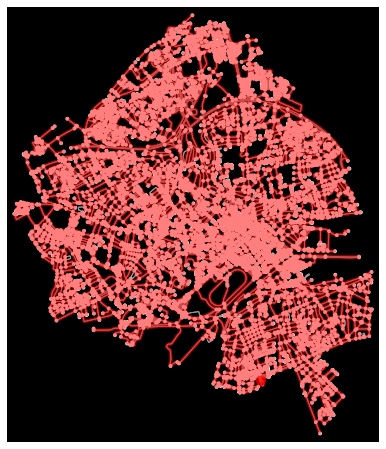

In [20]:
path_real_id = to_real_id_path(caen_path_drone)
#print(path_real_id)
fig, ax = ox.plot_graph_route(G, path_real_id, route_linewidth=3, bgcolor='black')

### 1.2 Calcul du parcours le plus efficace pour le drone ###

In [ ]:
#ICI on fait l'algo

In [ ]:
# ICI ON AFFICHE
#fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k') --> afficher le parcours avec une liste noeud

### 1.3 Recuperation des données du drones (simulation d'eneigement) ###